
Dataset Description
train.csv: A full training dataset with the following attributes:
id: unique id for a news article
title: the title of a news article
author: author of the news article
text: the text of the article; could be incomplete
label: a label that marks the article as potentially unreliable
1: unreliable
0: reliable
test.csv: A testing training dataset with all the same attributes at train.csv without the label.

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
import itertools
from sklearn.metrics import classification_report

In [36]:
data=pd.read_csv('C:/Users/bandl/Downloads/fake_news/train.csv')


In [3]:
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
#Null Value Check
data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [5]:
#Shape Of The DAtaset
data.shape

(20800, 5)

In [6]:
#using only title column dropping others
data=data.drop(['text','author','id'],axis=1)

In [7]:

data.isnull().sum()

title    558
label      0
dtype: int64

In [8]:
#Dropping NaN VAlues
data=data.dropna()

In [9]:
data.isnull().sum()

title    0
label    0
dtype: int64

In [10]:
data.shape

(20242, 2)

In [11]:
data.head()

,title,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,Why the Truth Might Get You Fired,1
3,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,1


In [12]:
X=data['title']
y=data['label']

In [13]:
X.shape

(20242,)

In [14]:
#dropped some nan values,reset index makes them uniform
X=X.reset_index()

In [15]:
X=X.drop(['index'],axis=1)

In [16]:
X.tail()

,title
20237,Rapper T.I.: Trump a ’Poster Child For White S...
20238,"N.F.L. Playoffs: Schedule, Matchups and Odds -..."
20239,Macy’s Is Said to Receive Takeover Approach by...
20240,"NATO, Russia To Hold Parallel Exercises In Bal..."
20241,What Keeps the F-35 Alive


In [17]:
#as rows dropeed so to make the dataframe in order
y=y.reset_index()

In [18]:
y=y.drop(['index'],axis=1)

In [19]:
y.tail()

,label
20237,0
20238,0
20239,0
20240,1
20241,1


In [20]:
ps = PorterStemmer()
corpus = []
#each row of the dataset is considered here.everything except the alphabets are removed ,stopwords are also being removed here .the text is converted in lowercase letters and stemming is performed
#lemmatisation can also be used here at the end a corpus of sentences is created
for i in range(0, len(X)):
    review = re.sub('[^a-zA-Z]', ' ',X['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [21]:
corpus[30]

'chuck todd buzzfe eic publish fake news breitbart'

In [22]:
#vocabulary size
voc_size=5000

In [23]:
#performing onr hot representation
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [24]:
len(onehot_repr[0])

10

In [25]:
len(onehot_repr[700])

5

In [26]:
#specifying a sentence length so that every sentence in the corpus will be of same length
sent_length=25
#using padding for creating equal length sentences
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 4552 2664 4613]
 [   0    0    0 ... 2525 1896 4296]
 [   0    0    0 ... 3457 1212 4498]
 ...
 [   0    0    0 ... 3835  460 3210]
 [   0    0    0 ... 3427 2540 2561]
 [   0    0    0 ...  500 2058 4599]]


In [27]:
#Creating model
from tensorflow.keras.layers import Dropout
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(200))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [28]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [29]:
X_final.shape,y_final.shape

((20242, 25), (20242, 1))

In [30]:
#splitting the data for training and testing the model

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.10, random_state=42)

In [31]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64)

Epoch 1/20
285/285 [==============================] - 10s 28ms/step - loss: 0.2894 - accuracy: 0.8720 - val_loss: 0.1980 - val_accuracy: 0.9170
Epoch 2/20
285/285 [==============================] - 8s 27ms/step - loss: 0.1379 - accuracy: 0.9445 - val_loss: 0.1984 - val_accuracy: 0.9215
Epoch 3/20
285/285 [==============================] - 10s 35ms/step - loss: 0.1022 - accuracy: 0.9608 - val_loss: 0.2040 - val_accuracy: 0.9220
Epoch 4/20
285/285 [==============================] - 14s 48ms/step - loss: 0.0740 - accuracy: 0.9744 - val_loss: 0.2492 - val_accuracy: 0.9205
Epoch 5/20
285/285 [==============================] - 9s 33ms/step - loss: 0.0555 - accuracy: 0.9797 - val_loss: 0.2768 - val_accuracy: 0.9210
Epoch 6/20
285/285 [==============================] - 8s 28ms/step - loss: 0.0424 - accuracy: 0.9848 - val_loss: 0.2899 - val_accuracy: 0.9165
Epoch 7/20
285/285 [==============================] - 11s 38ms/step - loss: 0.0365 - accuracy: 0.9875 - val_loss: 0.3260 - val_accuracy: 0.

In [32]:
classes_x = (model.predict(X_test) > 0.5).astype("int32")

In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, classes_x)

array([[910, 108],
       [ 63, 944]], dtype=int64)

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,classes_x)

0.9155555555555556

In [45]:
# Function to plot confusion Matrix
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Confusion matrix, without normalization


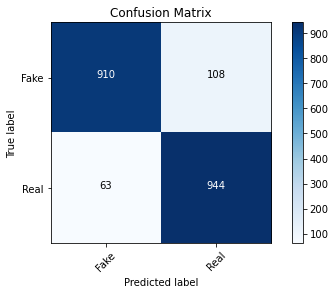

In [46]:
cm = metrics.confusion_matrix(y_test, classes_x)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [49]:
classification_report(y_test, classes_x)

'              precision    recall  f1-score   support\n\n           0       0.94      0.89      0.91      1018\n           1       0.90      0.94      0.92      1007\n\n    accuracy                           0.92      2025\n   macro avg       0.92      0.92      0.92      2025\nweighted avg       0.92      0.92      0.92      2025\n'